# Partitioning

The system makes use of three different (train, predict) partitioning schemes, used at different points in the process. The three are currently given in the following form:

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}

test_partitioner_dict = {"train":(121,444),"predict":(445,492)}

future_partitioner_dict = {"train":(121,492),"predict":(493,504)}

The numbers are month numbers, defined as number of months since December 1979. 444, then, is December 2015, and 504 December 2021. We change the periods for each of these partitions regularly, typically after an annual update of the most important input data is ready, and, in the case of the future partition, for each monthly update. For calibration and testing purposes, the 'predict' parts are 48 consecutive months.

The number of schemes is due to how VIEWS is training models in multiple stages -- using all data available while avoiding data leakage for the purposes of hyper-parameter tuning (short-hand for procedures for calibration, training model weights, and other hyper-parameter settings), testing of model performance, and future prediction.

The 'calib_partitioner' is used for hyper-parameter tuning for test purposes, the 'test_partitioner' for model training for test purposes as well as for hyper-parameter tuning for future predictions, and the 'future_partitioner' for model training for future predictions. In other words, when we do a run to test the performance of the model system, we do the following:

- train the constituent models on the 'train' part of the calib_partitioner, predict on the 'predict' part of the same, train the hyper-parameters and ensemble weights on these predictions against the actuals in the 'predict' part of this partitioner
- retrain the constituent models with optimized hyper-parameters using the 'train' part of the test_partitioner, predict using the pre-trained ensemble weights for the 'predict' part of the test_partitioner, and evaluate these predictions against the actuals of this predict period.

For future predictions, we retrain all models to make use of all available data:

- train the constituent models on the 'train' part of the test_partitioner, predict on the 'predict' part of the same, train the hyper-parameters and ensemble weights on these predictions against the actuals in the 'predict' part of this partitioner
- retrain the constituent models with optimized hyper-parameters using the 'train' part of the future_partitioner, predict using the pre-trained ensemble weights for the 'predict' part of the future_partitioner. As true future predictions evaluation is not possible until at a later date.

In practice, the use of the partitioner is in fact a bit more involved than this, see the section on 'stepshifting' below.

In [1]:
# Use viewser env

from viewser import Queryset, Column
from ingester3.extensions import *
#from ingester3.DBWriter import DBWriter

import urllib.request
import os

import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
from pkg_resources import get_distribution
installed_version = get_distribution('ingester3').version

if installed_version >= '1.8.1':
    print (f"You are running version {installed_version} which is consistent with the documentation")
else:
    print (f"""
You are running an obsolete version ({installed_version}). Run:
pip install ingester3 --upgrade 
to upgrade""")

You are running version 1.8.4 which is consistent with the documentation


In [4]:
# Show a list of available transforms
#!viewser transforms list

# Show a list of available transforms
#!viewser tables list

#!viewser tables show priogrid_month

#!viewser tables show priogrid_year

#!viewser tables show country_month

#!viewser tables show country_year

#!viewser tables show ged2_pgm

#!viewser tables show month

#!viewser queryset list

In [5]:
def get_views_date(location, partitioner_dict):

    path_views_data = location + '/views_data.pkl'

    if os.path.isfile(path_views_data) == True:

        print('File already downloaded')
        df = pd.read_pickle(path_views_data)
        
    else:
        print('Beginning file download through viewser...')

        # queryset_base = (Queryset("simon_tests", "priogrid_month")
        #     .with_column(Column("sb_best_count_pgm", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi").transform.ops.ln().transform.missing.replace_na()))

        queryset_base = (Queryset("simon_tests", "priogrid_month")
            .with_column(Column("sb_best_count_pgm", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi").transform.ops.ln().transform.missing.replace_na())
            .with_column(Column("sb_high_count_pgm", from_table = "ged2_pgm", from_column = "ged_sb_high_count_nokgi").transform.ops.ln().transform.missing.replace_na())
            .with_column(Column("month", from_table = "month", from_column = "month"))
            .with_column(Column("year_id", from_table = "country_year", from_column = "year_id"))
            .with_column(Column("c_id", from_table = "country_year", from_column = "country_id")))


        # You want high, and you want ns and os.

        df = queryset_base.publish().fetch()

        df.reset_index(inplace = True)

        df.rename(columns={'priogrid_gid': 'pg_id', 'sb_best_count_pgm' : 'ln_sb_best', 'sb_high_count_pgm' : 'ln_sb_high'}, inplace= True)


        
        # df = df[df['month_id'] == 121] # temp sub
        # df = df[df['month_id'].isin([121, 122, 123, 124])] # temp sub
        
        
        #month_range = np.arange(partitioner_dict['train'][0],partitioner_dict['predict'][1]+1,1)
        month_range = np.arange(partitioner_dict['train'][0],partitioner_dict['train'][0]+11,1)

        df = df[df['month_id'].isin(month_range)] # temp sub


        #df['lat'] = df.pg.lat # already in PRIO grid as ycoord
        #df['lon'] = df.pg.lon # already in PRIO grid as xcoord

        #df['month'] = df.pgm.month # See if these can be optained through a query_set
        #df['year_id'] = df.pgm.year # See if these can be optained through a query_set
        #df['row'] = df.pgm.row # already in PRIO grid as row
        #df['col'] = df.pgm.col # already in PRIO grid as col

        #df['c_id'] = df.pgy.c_id # See if these can be optained through a query_set

        df['in_viewser'] = True
        # df['name'] = df.cy.name # No need
        df.to_pickle(path_views_data)

        print('VIEWS data pickled.')

    return df

In [6]:
def get_prio_shape(location):

    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    prio_grid.rename(columns={'gid': 'pg_id'}, inplace= True)

    return prio_grid

In [7]:
def monthly_grid(prio_grid, views_df):

    years = [sorted(views_df['year_id'].unique())] * prio_grid.shape[0]
    #months = [list(np.arange(1, 13))] * prio_grid.shape[0]

    months = [sorted(views_df['month'].unique())] * prio_grid.shape[0] # then you only get one for the test runs# expensive to get these

    prio_grid['year_id'] = years
    prio_grid['month'] = months

    prio_grid = prio_grid.explode('year_id').reset_index(drop=True) 
    prio_grid = prio_grid.explode('month').reset_index(drop=True) 

    prio_grid['year_id'] = prio_grid['year_id'].astype(int)
    prio_grid['month'] = prio_grid['month'].astype(int)

    # # Add month_id:
    # prio_grid['year_month'] = prio_grid['year'].astype(str) + '_' + prio_grid['month'].astype(str)
    # month_ids = np.arange(views_df['month_id'].min(), views_df['month_id'].max()+1, 1)
    
    # # Hack, but it works
    # ts = prio_grid['year_month'].unique()
    # month_id_df = pd.DataFrame({'year_month' : ts, 'month_id': month_ids})
    # prio_grid = prio_grid.merge(month_id_df, on = 'year_month', how = 'left')

    # Merge
    # full_grid = prio_grid.merge(views_df, on = ['pg_id', 'year_id', 'month', 'col', 'row'], how = 'left')
    full_grid = prio_grid.merge(views_df, on = ['pg_id', 'year_id', 'month'], how = 'left')

    full_grid.fillna({'ln_sb_best' : 0, 'ln_sb_high' : 0, 'c_id' : 0, 'in_viewser' : False}, inplace = True) # for c_id 0 is no country

    full_grid["month_id"] = full_grid.groupby("month").transform(lambda x: x.fillna(x.mean(skipna = True)))['month_id'] # I think this is cool, but must check...

    # Drop stuff..

    return full_grid

In [8]:
def get_sub_grid(grid, views_df):

        views_gids = views_df['pg_id'].unique()

        # get both dim to 180. Fine since you maxpool(2,2) two time: 180 -> 90 -> 45
        # A better number might be 192 since: 192 -> 96 -> 48 -> 24 -> 12 -> 6 -> 3
        max_coords = grid[grid['pg_id'].isin(views_gids)][['xcoord', 'ycoord']].max() + (1,1) 
        min_coords = grid[grid['pg_id'].isin(views_gids)][['xcoord', 'ycoord']].min() - (1,0.25) 
        
        # Maks it
        mask1 = ((grid['xcoord'] < max_coords[0]) & (grid['xcoord'] > min_coords[0]) & (grid['ycoord'] < max_coords[1]) & (grid['ycoord'] > min_coords[1]))
        grid = grid[mask1].copy()

        return grid

In [9]:
def make_volumn(grid):

    # we start with wat we know - but there is no reason not to try with more down til line.

    sub_df = grid[['pg_id', 'xcoord', 'ycoord', 'month_id', 'c_id', 'ln_sb_best', 'ln_sb_high']].copy() # remove the everything also the geo col. What about in_viewser?

    sub_df_sorted = sub_df.sort_values(['month_id', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = sub_df['xcoord'].unique().shape[0]
    y_dim = sub_df['ycoord'].unique().shape[0]
    z_dim = sub_df['month_id'].unique().shape[0]

    ucpd_vol = np.array(sub_df_sorted).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol

In [10]:
def compile():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/number_one/Documents/scripts/conflictNet/data/raw'

    calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}

    test_partitioner_dict = {"train":(121,444),"predict":(445,492)}

    future_partitioner_dict = {"train":(121,492),"predict":(493,504)}


    df = get_views_date(location, calib_partitioner_dict)
    print('done 1')
    grid = get_prio_shape(location)
    print('done 2')
    grid = monthly_grid(grid, df)
    print('done 3')
    grid = get_sub_grid(grid, df)
    print('done 4')
    
    return grid

# Make grid

In [11]:
grid = compile(location)

File already downloaded
done 1
File already downloaded
done 2
done 3
done 4


In [12]:
grid['month_id'].unique()

array([121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.])

In [13]:
print(len(grid['xcoord'].unique()))
print(len(grid['ycoord'].unique()))

180
180


In [14]:
grid.head()

,pg_id,xcoord,ycoord,col,row,year_id,month,month_id,c_id,ln_sb_best,ln_sb_high,in_viewser
746735,191288,63.75,42.75,488,266,1990,1,121.0,0.0,0.0,0.0,False
746736,191288,63.75,42.75,488,266,1990,2,122.0,0.0,0.0,0.0,False
746737,191288,63.75,42.75,488,266,1990,3,123.0,0.0,0.0,0.0,False
746738,191288,63.75,42.75,488,266,1990,4,124.0,0.0,0.0,0.0,False
746739,191288,63.75,42.75,488,266,1990,5,125.0,0.0,0.0,0.0,False


In [15]:
(grid['ln_sb_high'] == grid['ln_sb_best']).mean() 

1.0

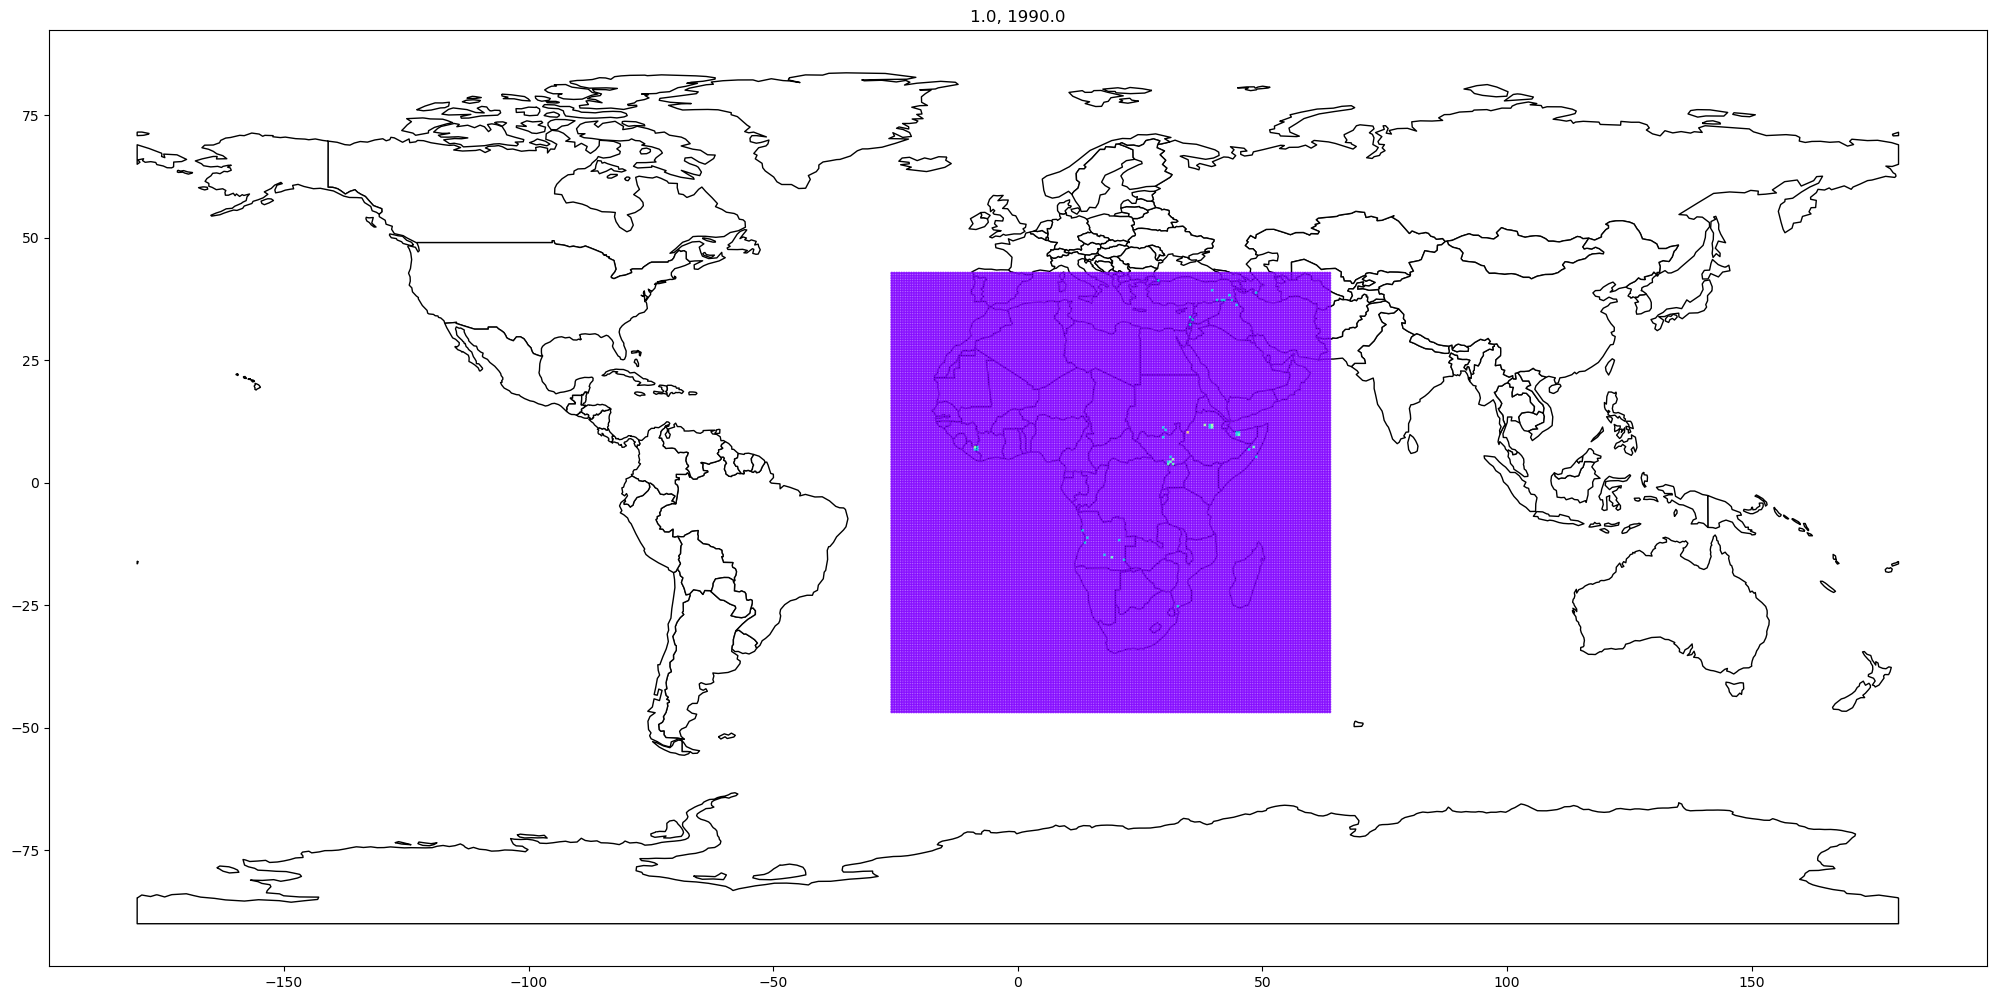

In [16]:
mask = (grid['month_id'] == 121) #& (grid['in_viewser'] == True)

x = grid.loc[mask, 'xcoord']
y = grid.loc[mask, 'ycoord']

s = grid.loc[mask,'ln_sb_best']

base = world.plot(color='white', edgecolor='black', figsize = [25,25])

base.scatter(x, y, s= 6, c = s, marker= '.', cmap = 'rainbow', alpha =0.8, vmin = 0, vmax = grid['ln_sb_best'].max())

title = f"{grid.loc[mask, 'month'].mean()}, {grid.loc[mask, 'year_id'].mean()}"
plt.title(title)

plt.show()

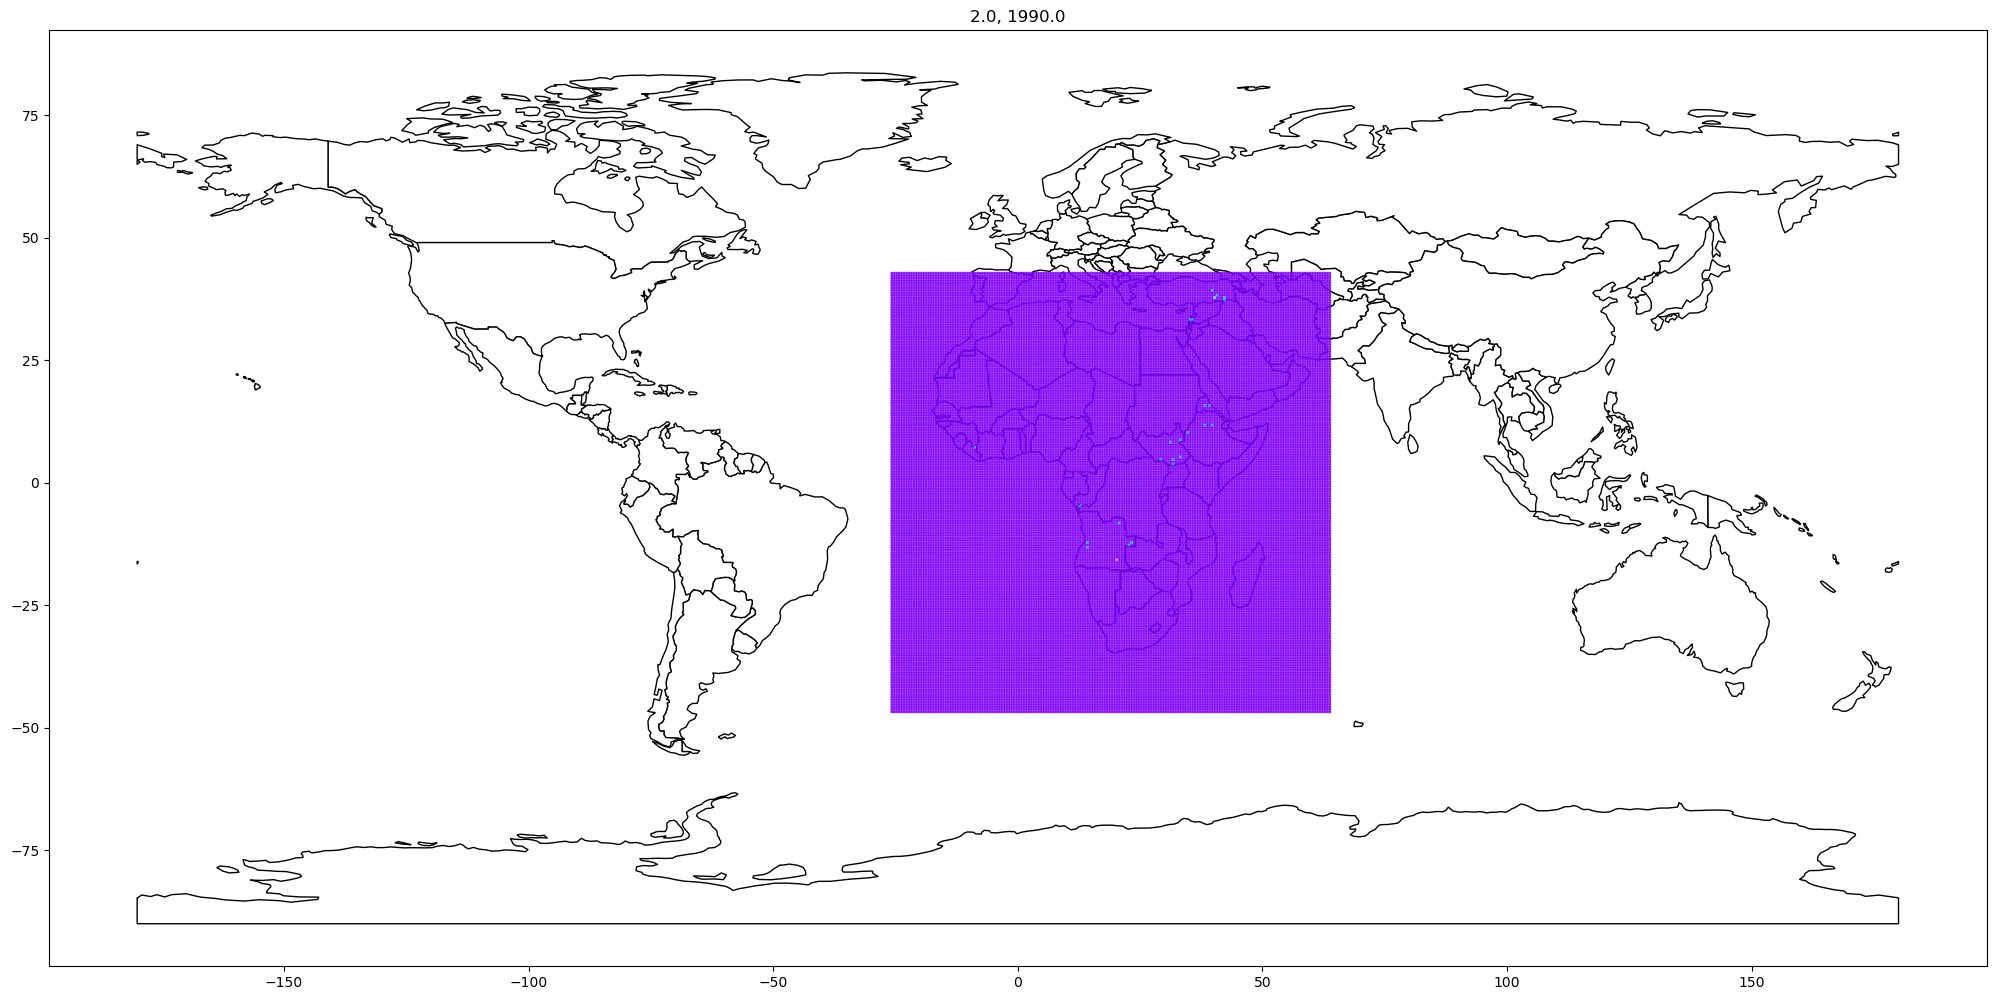

In [17]:
mask = (grid['month_id'] == 122) #& (grid['in_viewser'] == True)

x = grid.loc[mask, 'xcoord']
y = grid.loc[mask, 'ycoord']

s = grid.loc[mask,'ln_sb_best']

base = world.plot(color='white', edgecolor='black', figsize = [25,25])

base.scatter(x, y, s= 6, c = s, marker= '.', cmap = 'rainbow', alpha =0.8, vmin = 0, vmax = grid['ln_sb_best'].max())

title = f"{grid.loc[mask, 'month'].mean()}, {grid.loc[mask, 'year_id'].mean()}"
plt.title(title)

plt.show()

# Make volumn

In [18]:
vol = make_volumn(grid)

In [19]:
vol.shape

(11, 180, 180, 7)

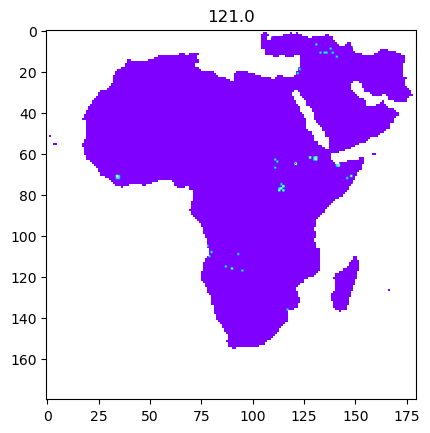

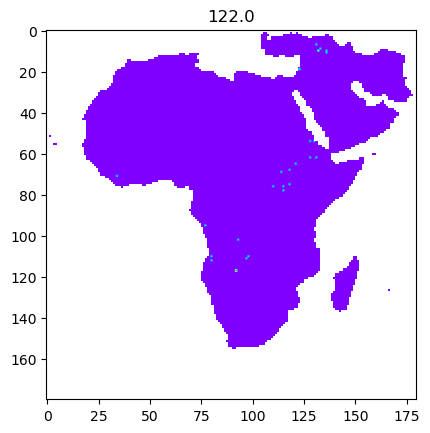

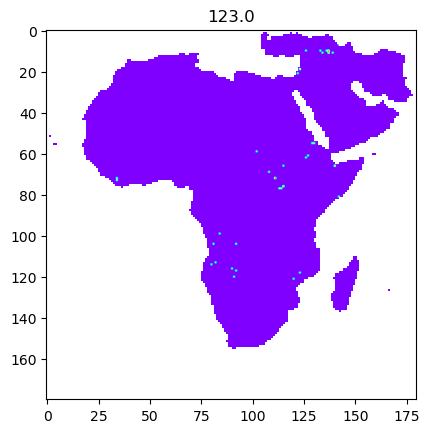

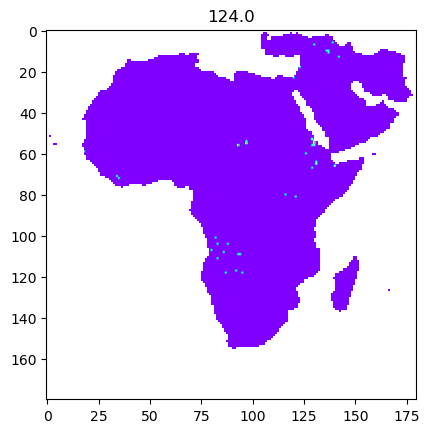

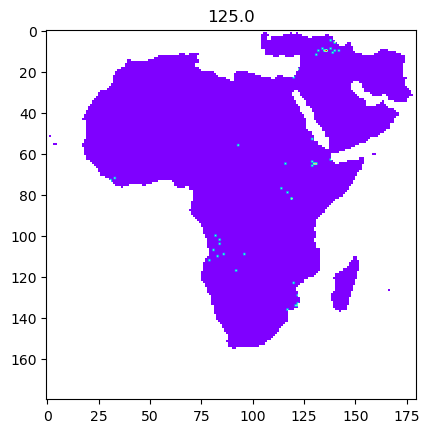

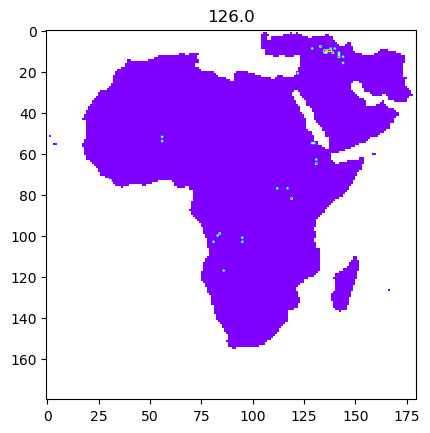

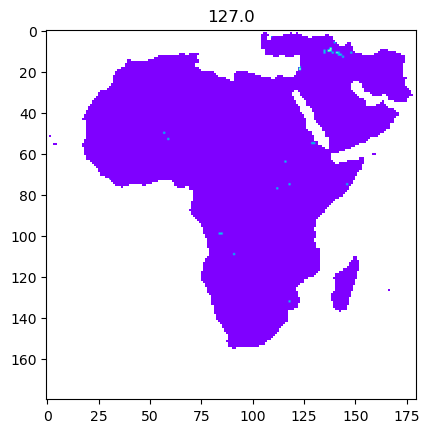

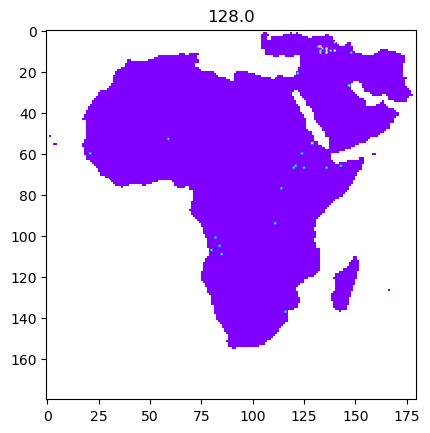

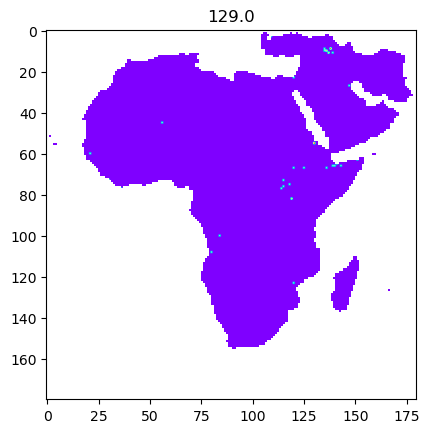

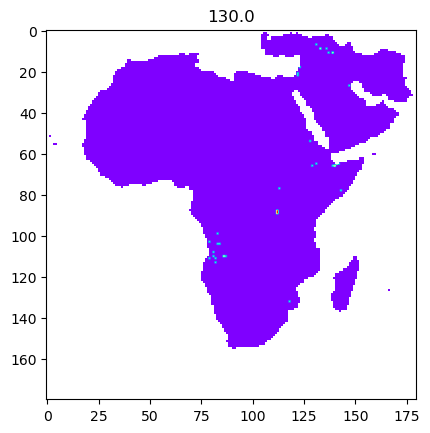

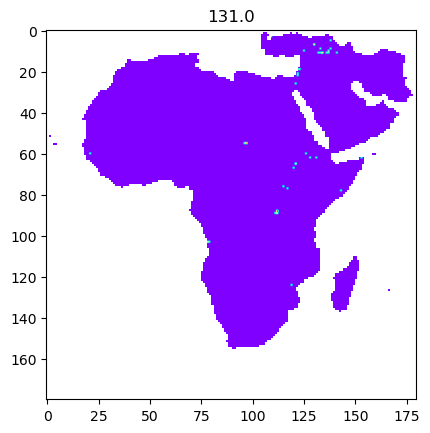

In [20]:
for i in range(vol.shape[0]):
    true_obs_masked = np.ma.masked_where((vol[0,:,:,4] == 0), vol[i,:,:,5])
    plt.imshow(true_obs_masked, cmap = 'rainbow')
    plt.title(vol[i,:,:,3].mean())
    plt.show()

# OLD

In [ ]:
pg_example = Priogrid(138291)
print(pg_example)


In [ ]:
queryset_base = (Queryset("simon_tests", "priogrid_month")
            # target variable
            .with_column(Column("sb_best_count_pgm", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi").transform.missing.replace_na().transform.ops.ln())
            )

In [ ]:
queryset_base = (Queryset("simon_tests", "priogrid_month")
            # target variable
            .with_column(Column("sb_best_count_pgm", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi"))
            .with_column(Column("sb_high_count_pgm", from_table = "ged2_pgm", from_column = "ged_sb_high_count_nokgi"))
            .with_column(Column("ln_pop_gpw_sum", from_table = "priogrid_year", from_column = "pop_gpw_sum"))
            .with_column(Column("greq_1_excluded", from_table = "priogrid_year", from_column = "excluded"))
            .with_column(Column("pgd_imr_mean", from_table = "priogrid_year", from_column = "imr_mean"))
            .with_column(Column("ln_pgd_ttime_mean", from_table = "priogrid_year", from_column = "ttime_mean"))
            .with_column(Column("pgd_urban_ih", from_table = "priogrid_year", from_column = "urban_ih"))
            )


# acled_sb_count
#.with_column(Column("vdem_v2x_delibdem", from_table = "vdem_v12_cy", from_column = "vdem_v12_v2x_delibdem")
# , transformations = ["ops.ln", "missing.replace_na"]

In [ ]:
df = queryset_base.publish().fetch()
df.reset_index(inplace = True)
df.rename(columns={'priogrid_gid': 'pg_id'}, inplace= True)

In [ ]:
sub_df = df.iloc[500000:500010,:]
sub_df['lat'] = sub_df.pg.lat
sub_df['lon'] = sub_df.pg.lon

sub_df['month'] = sub_df.pgm.month
sub_df['year_id'] = sub_df.pgm.year
sub_df['row'] = sub_df.pgm.row
sub_df['col'] = sub_df.pgm.col

sub_df['c_id'] = sub_df.pgy.c_id
sub_df['name'] = sub_df.cy.name

sub_df

In [ ]:
sub_df = df.iloc[500000:500010,:]
sub_df['lat'] = sub_df.pg.lat
sub_df['lon'] = sub_df.pg.lon

sub_df['month'] = sub_df.pgm.month
sub_df['year_id'] = sub_df.pgm.year
sub_df['row'] = sub_df.pgm.row
sub_df['col'] = sub_df.pgm.col

sub_df['c_id'] = sub_df.pgy.c_id
sub_df['name'] = sub_df.cy.name

sub_df

In [ ]:
sub_df = df.iloc[500000:500010,:]
sub_df['lat'] = sub_df.pg.lat
sub_df['lon'] = sub_df.pg.lon

sub_df['c_id'] = sub_df.pg.c_id
#sub_df['name'] = sub_df.cy.name
sub_df['year_id'] = sub_df.pgm.year
sub_df['month'] = sub_df.pgm.month

sub_df['row'] = sub_df.pgm.row
sub_df['col'] = sub_df.pgm.col


In [ ]:
# you have enough to make a plot if you wnat too.
sub_df.c.full_set(in_africa= True, in_me= True)

In [ ]:
sub_df.pg.full_set(land_only =True)

In [ ]:
sub_df

In [ ]:
sub_df.m.datetime

In [ ]:
39/12


In [ ]:
print(ViewsMonth(800))

In [ ]:


Views_month = ViewsMonth(100)
print(Views_month)



In [ ]:
sub_df.loc[[0]].queen_contiguity()

In [ ]:
Priogrid(62356).country()

In [ ]:
Country(150).gwcode

In [ ]:
country

# queen_contiguity

This just needs to be expandeed in size and you need a way to insure informative grids....

In [ ]:
example_pg = Priogrid.from_row_col(row=250, col=300)
print(example_pg)

In [ ]:
example_pg.queen_contiguity()

# OLD

In [ ]:
test_cm = pd.DataFrame({'ISO':['ITA','SWE','NOR','dza','NOR','NOR','NOR'],
                             'month_id':[401,401,404,404,403,402,402],
                             'some_test_value':[1,2,4,5,9,2,1],
                             'test_score':  [0,1,2,3,4,8,9],
                             'some_other_data':[109,None,2,2,92,7,None]})
test_cm

In [ ]:
pd.DataFrame.cm.from_iso(test_cm, iso_col='ISO', month_col='month_id')

In [ ]:
queryset_base = (Queryset("simon_tests", "priogrid_month")
            # target variable
            .with_column(Column("sb_count_pgm", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi")))

In [ ]:
df = queryset_base.publish().fetch()

In [ ]:
df.reset_index(inplace = True)
df.rename(columns={'priogrid_gid': 'pg_id'}, inplace= True)

In [ ]:
df[df['sb_count_pgm'] > 0].head()

In [ ]:
sub_df = df.iloc[0:10,:]
sub_df['lat'] = sub_df.pg.lat
sub_df['lon'] = sub_df.pg.lon

In [ ]:
sub_df.pg.train_set

In [ ]:
sub_df.pgm.

In [ ]:
df['month_id'].unique().shape

In [ ]:
df['lat'] = df.pg.lat
df['lon'] = df.pg.lon

In [ ]:
852/12

In [ ]:
df.pg.lat and df.pg.lon.

In [ ]:
queryset_base = (Queryset("simon_tests", "country_month")
            # target variable
            .with_column(Column("sb_count_cm", from_table = "ged2_cm", from_column = "ged_sb_best_count_nokgi"))
            .with_column(Column("sb_acled_cm", from_table = 'acled2_cm', from_column = "acled_sb_count"))
           )

In [ ]:

from ingester3.scratch import cache_manager

cache_manager()


In [ ]:
queryset_base = (Queryset("simon_tests", "country_year"))

In [ ]:
queryset_base = (Queryset("simon_tests", "priogrid_year"))

In [ ]:
a0 = queryset_base.publish().fetch()

In [ ]:
assert a0.loc[501].loc[60].sb_count_cm ==  27
assert a0.loc[501].loc[60].sb_acled_cm == 333

assert a0.shape[0] == 158230

assert ViewsMonth(500).month == 8
assert Country.from_iso('DZA').name == 'Algeria'

print(f"Query works for retreiving {a0.shape}")

In [ ]:
a0.head()